# This project will be a continuation of Project 1 (see attached report and notebook). This time, for all missing values, we will fill with the averages for the columns rather than by performing row-wise elemination. We set the per-test significance level 𝛼 to 0.005 (as per Benjamin et al., 2018). 

In [8]:
#!/usr/bin/env python

import importlib
from myModules import movieClass
importlib.reload(movieClass)
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as  plt
from labellines import labelLines

Movies = movieClass.movie(verbose=False, alpha=0.005)

stuff

In [9]:
usrData = pd.DataFrame(Movies.userData()).T
names = ['User ' + str(i) for i in range(len(usrData.columns))]
usrData.columns = names

corr = usrData.corr().abs()
#keep lower triangular without the diagonal
corr[:] = np.tril(corr.values, k=-1)
corrMax = corr.max()
megaMax = corrMax.max()

pairs = []

i = 0
for usr in names:   
    match = corr.index[corr[usr] == corrMax[i]].tolist()
    pairs.append((usr,*match,'Coefficient of ' + str(corrMax[i])))
    i+=1

corrUsers = []
for i in range(10):
    corrUsers.append(pairs[i][1])
string = "The most correlated users for users 0 to 9 were as follows: {list}.".format(list=corrUsers)
print(string)

for pair in pairs:
    if pair[2] == 'Coefficient of ' + str(megaMax):
        megaPair = (pair[0],pair[1])
        break
string = "The most correlated pair of users is pair {pair} with coefficient of {coeff}.".format(pair=megaPair, coeff=megaMax)
print(string)

The most correlated users for users 0 to 9 were as follows: ['User 583', 'User 831', 'User 896', 'User 364', 'User 896', 'User 99', 'User 239', 'User 896', 'User 896', 'User 1004'].
The most correlated pair of users is pair ('User 831', 'User 896') with coefficient of 0.999542426149521.


stuff

In [10]:
#For missing entries, avg from the column used. Personal columns are from 401 to 474. First 400 are movie ratings.
Movies = movieClass.movie(verbose=False,alpha=0.005,fillAvg=True)
data = Movies.columnData(fillAvg=True, dropNan = False)
df_rate = pd.DataFrame(data[:Movies.movieCols])
df_pers = pd.DataFrame(data[Movies.movieCols:-3])

#80% for training set, 20% for test
#Model df_pers = function(df_rate)
x_train,x_test,y_train,y_test=train_test_split(df_rate.T,df_pers.T,test_size=0.2, random_state = 42)

# We're going to focus particularly on sensation-seeking behaviors (Columns 401-421) as they all query from a set of questions that lie on a risky/high energy-to-risk-averse spectrum 
# and will be aggregated to form our dependent vector  

Y_train = y_train.iloc[:,0:20].agg('sum',axis='columns')# dependent variables (really, y_hat + residuals, y = (B_0 * x_0 +...+ B_76 * x_76) + e for ALL users, so multiple OLS)
Y_test = y_test.iloc[:,0:20].agg('sum',axis='columns')

stuff


In [11]:
# OLS Model
model = linear_model.LinearRegression().fit(x_train, Y_train)  # fitting the model
#Predict function is model.intercept_ + np.dot(x_train, model.coef_)
yhat_test = model.predict(x_test)
yhat_train = model.predict(x_train)

train_MAE_OLS = mean_absolute_error(Y_train.values, yhat_train) 
test_MAE_OLS = mean_absolute_error(Y_test.values, yhat_test)

print(train_MAE_OLS)
print(test_MAE_OLS)


4.33650858191135
10.113663052962973


stuff


In [12]:
# Ridge Regression Version
alphas_RR = [0, 1e-8, 1e-5, .1, 1, 10]
model_alphas_RR = []
for a in alphas_RR:
    model = linear_model.Ridge(alpha=a).fit(x_train, Y_train)
    yhat_test = model.predict(x_test)
    yhat_train = model.predict(x_train)
    train_MAE_RR = mean_absolute_error(Y_train.values, yhat_train) 
    test_MAE_RR = mean_absolute_error(Y_test.values, yhat_test)
    model_alphas_RR.append((train_MAE_RR,test_MAE_RR))

prime_alpha_ridge = alphas_RR[model_alphas_RR.index(min(model_alphas_RR, key = lambda t: t[1]))]
print(prime_alpha_ridge)


10


stuff

In [13]:
#Lasso Regression Version
alphas_LSO = [1e-3,1e-2,1e-1,1]
log_lasso = []
model_alphas_LSO = []
for a in alphas_LSO:
    model = linear_model.Lasso(alpha=a, max_iter=10000).fit(x_train, Y_train)
    log_lasso.append(model)
    yhat_test = model.predict(x_test)
    yhat_train = model.predict(x_train)
    train_MAE_LSO = mean_absolute_error(Y_train.values, yhat_train) 
    test_MAE_LSO = mean_absolute_error(Y_test.values, yhat_test)
    model_alphas_LSO.append((train_MAE_LSO,test_MAE_LSO))

prime_alpha_lasso = alphas_LSO[model_alphas_LSO.index(min(model_alphas_LSO, key = lambda t: t[1]))]
print(prime_alpha_lasso)

0.1


stuff


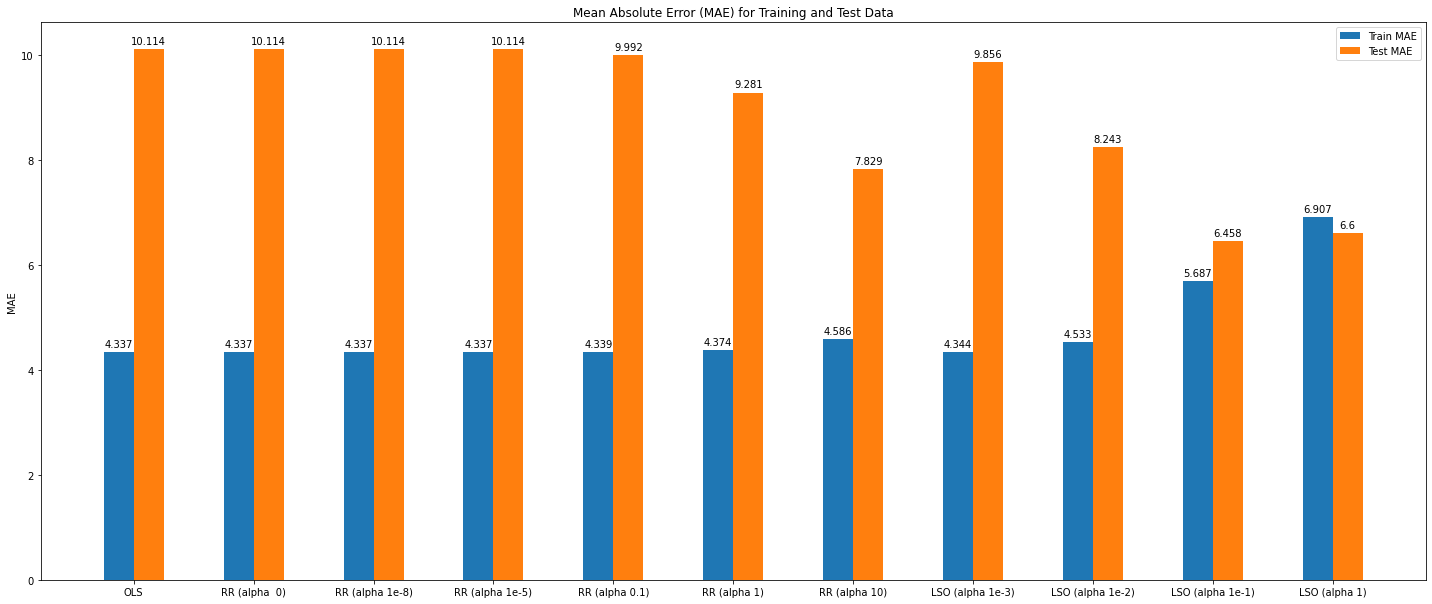

In [14]:
plt.rcParams["figure.figsize"] = [20.00, 8.50]
plt.rcParams["figure.autolayout"] = True
labels = ['OLS', 'RR (alpha  0)', 'RR (alpha 1e-8)', 'RR (alpha 1e-5)', 'RR (alpha 0.1)', 'RR (alpha 1)', 'RR (alpha 10)',
'LSO (alpha 1e-3)', 'LSO (alpha 1e-2)', 'LSO (alpha 1e-1)', 'LSO (alpha 1)']
mae_train = [train_MAE_OLS, model_alphas_RR[0][0], model_alphas_RR[1][0], model_alphas_RR[2][0], model_alphas_RR[3][0], model_alphas_RR[4][0],
model_alphas_RR[5][0],model_alphas_LSO[0][0], model_alphas_LSO[1][0], model_alphas_LSO[2][0], model_alphas_LSO[3][0]]
mae_train = [round(i,3) for i in mae_train]

mae_test = [test_MAE_OLS, model_alphas_RR[0][1], model_alphas_RR[1][1], model_alphas_RR[2][1], model_alphas_RR[3][1], model_alphas_RR[4][1],
model_alphas_RR[5][1], model_alphas_LSO[0][1], model_alphas_LSO[1][1], model_alphas_LSO[2][1], model_alphas_LSO[3][1]]
mae_test = [round(i,3) for i in mae_test]

x = np.arange(len(labels))
width = 0.25
fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, mae_train, width, label='Train MAE')
rects2 = ax.bar(x + width / 2, mae_test, width, label='Test MAE')

ax.set_ylabel('MAE')
ax.set_title('Mean Absolute Error (MAE) for Training and Test Data')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
   for rect in rects:
      height = rect.get_height()
      ax.annotate('{}'.format(height),
         xy=(rect.get_x() + rect.get_width() / 2, height),
         xytext=(0, 3), # 3 points vertical offset
         textcoords="offset points",
         ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.show()


stuff

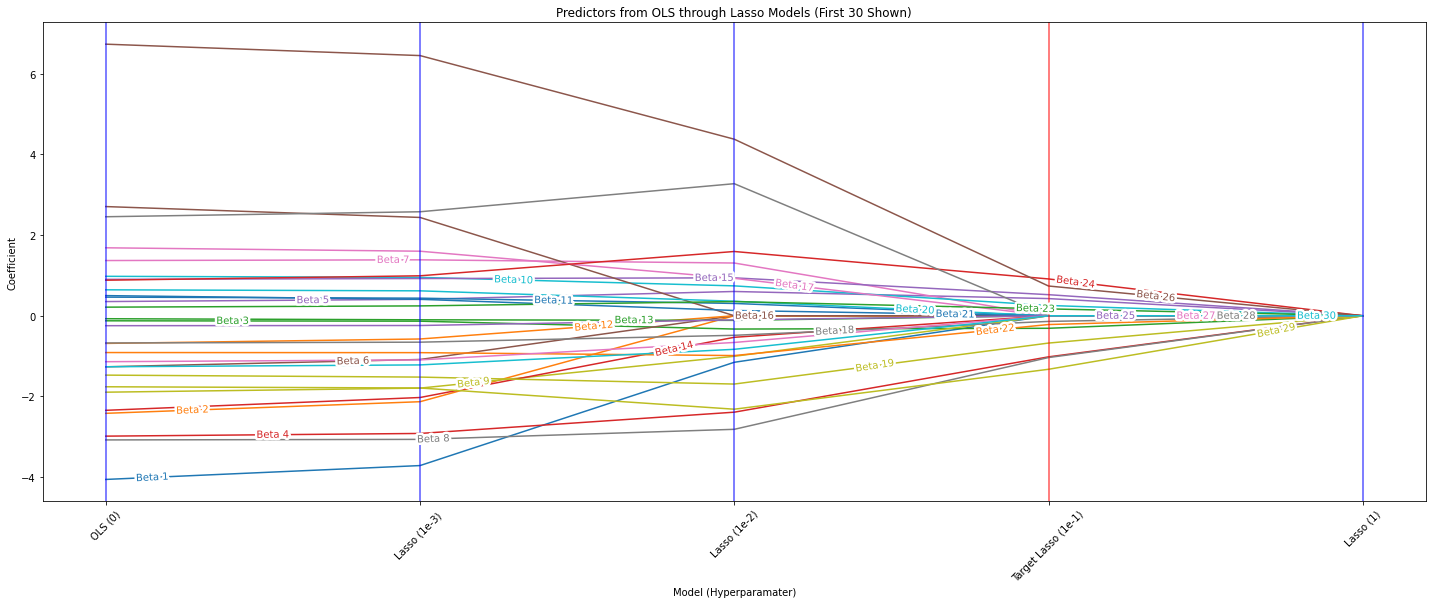

In [15]:

baseline = linear_model.LinearRegression().fit(x_train, Y_train)
prime_model = log_lasso[-2]
labels = ['Beta ' + str(i+1) for i in range(len(prime_model.coef_)-370)]
for i in range(len(prime_model.coef_)-370):
    x1 = 0
    y1 = baseline.coef_[i]

    x2 = 1
    y2 = log_lasso[0].coef_[i]

    x3 = 2
    y3 = log_lasso[1].coef_[i]

    x4 = 3
    y4 = log_lasso[2].coef_[i]

    x5 = 4
    y5 = log_lasso[3].coef_[i]

    x_val = [x1,x2,x3,x4,x5]
    y_val = [y1,y2,y3,y4,y5]

    plt.plot(x_val,y_val, label=labels[i])

#specify x-axis locations
x_ticks = x_val
#specify x-axis labels (lambdas)
x_labels = ['OLS (0)', 'Lasso (1e-3) ', 'Lasso (1e-2)', 'Target Lasso (1e-1)', 'Lasso (1)'] 

#add x-axis values to plot
plt.xticks(ticks=x_ticks, labels=x_labels, rotation=45)

for tick in plt.xticks()[0]: 
    if tick == 3:
        plt.axvline(tick, color='red', linestyle='-', linewidth=2, alpha=.5)
    else:
        plt.axvline(tick, color='blue', linestyle='-', linewidth=2, alpha=.5)


labelLines(plt.gca().get_lines(), zorder=2.5)
plt.ylabel('Coefficient')
plt.xlabel('Model (Hyperparamater)')
plt.title('Predictors from OLS through Lasso Models (First 30 Shown)')
plt.show()

stuff